In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
N = 20000

In [3]:
ip = np.random.rand(N) > 0.5
ip = ip.astype(int)


In [4]:
s = 2 * ip - 1

In [5]:
Es = 1

In [6]:
eb_no_db = np.arange(0,25)

In [7]:
ber_RxMF_EPA = np.zeros(len(eb_no_db))

ber_RxZF_EPA = np.zeros(len(eb_no_db))

ber_RxMMSE_EPA = np.zeros(len(eb_no_db))

ber_RxMF_SVD_P = np.zeros(len(eb_no_db))

ber_RxZF_SVD_P = np.zeros(len(eb_no_db))

ber_RxMMSE_SVD_P = np.zeros(len(eb_no_db))

ber_SVD_CSIT = np.zeros(len(eb_no_db))

In [8]:
def calculate_ber(eb_no_db,nTx,nRx,jj,Rz,Rz_inverse,equalization_name):
    
    
    equalize_bits = []
    
    equalization_name = equalization_name
    
    for ii in range(N//2):
        
        H = (1/np.sqrt(2)) * (np.random.randn(nRx,nTx) + 1j * np.random.randn(nRx,nTx))
        
        n = (1/np.sqrt(2)) * (np.random.randn(2,1) + 1j * np.random.randn(2,1))
        
        x1 = s[2 * ii]
        
        x2 = s[2 * ii + 1]
        
        x =np.array([[x1],[x2]])
        
        
        
        Ns = np.linalg.matrix_rank(H)
        
        P = np.sqrt(Es / Ns) * np.vstack([
               np.eye(Ns),                
             np.zeros((nTx-Ns, Ns))           
          ])
        
        
        
        y = H @ P @ x + n * (10 ** (-eb_no_db[jj] / 20))
        
        
        H_hermitian = np.conjugate(H)
        
        H_hermitian = np.transpose(H_hermitian)
        
        P_hermitian = np.conjugate(P)
        
        P_hermitian = np.transpose(P_hermitian)
        
        if(equalization_name == "MF"):
            
                
            W = P_hermitian @ H_hermitian @ Rz_inverse

        elif(equalization_name == "ZF"):

            W = np.linalg.inv(P_hermitian @ H_hermitian @ Rz_inverse @ H @ P)\
                @ P_hermitian @ H_hermitian @ Rz_inverse 

        elif(equalization_name == "MMSE"):

            W = np.linalg.inv(np.eye(Ns)+P_hermitian @ H_hermitian @ Rz_inverse @ H @ P) \
              @ P_hermitian @ H_hermitian @ Rz_inverse
        
        x_hat = np.dot(W,y)
        
        x_hat = np.real(x_hat > 0).astype(int)
        
        equalize_bits.append(x_hat[0,0])
        
        equalize_bits.append(x_hat[1,0])
        
    nErr = np.sum(ip != equalize_bits)
    
    return nErr
         

In [9]:
def RxMF():
    
    
    for jj in range(len(eb_no_db)):
        
        nTx = 2
        
        nRx = 2
        
        snr = 10**(eb_no_db[jj] / 10)
        
        noise_variance = (1/snr)
        
        Rz = noise_variance * np.eye(nRx)
        
        Rz_inverse = np.linalg.inv(Rz)
        
        bit_error = calculate_ber(eb_no_db,nTx,nRx,jj,Rz,Rz_inverse,"MF")
        
        ber_RxZF_EPA[jj] = bit_error / N
        
        
    return ber_RxZF_EPA
        
        
        

In [10]:
def RxZF():
    
    for jj in range(len(eb_no_db)):
        
        nTx = 2
        
        nRx = 2
        
        snr = 10**(eb_no_db[jj] / 10)
        
        noise_variance = (1/snr)
        
        Rz = noise_variance * np.eye(nRx)
        
        Rz_inverse = np.linalg.inv(Rz)
        
        bit_error = calculate_ber(eb_no_db,nTx,nRx,jj,Rz,Rz_inverse,"ZF")
        
        ber_RxMF_EPA[jj] = bit_error / N
        
        
    return ber_RxMF_EPA
        
        

In [11]:
def RxMMSE():
    
    for jj in range(len(eb_no_db)):
        
        nTx = 2
        
        nRx = 2
        
        snr = 10**(eb_no_db[jj] / 10)
        
        noise_variance = (1/snr)
        
        Rz = noise_variance * np.eye(nRx)
        
        Rz_inverse = np.linalg.inv(Rz)
        
        bit_error = calculate_ber(eb_no_db,nTx,nRx,jj,Rz,Rz_inverse,"MMSE")
        
        ber_RxMMSE_EPA[jj] = bit_error / N
        
        
    return ber_RxMMSE_EPA
    

In [12]:
def sigma_two(noise_variance,S1,S2,q_optimal_1):
    
    S = [ S1 , S2 ]
    
    q_optimal_1 = q_optimal_1

    sigma_two_q  = []
    
    summation_part = 0
    
    for kk in range(len(S)):
        
        summation_part = summation_part +  (noise_variance/np.square(S[kk]))
        
    mu = (1/len(S))* (Es + summation_part)
    
    for mm in range(len(S)):
        
        qi = mu - (noise_variance/np.square(S[mm]))
        
        if(qi > 0):
            
            sigma_two_q.append(qi)
            
        else:
            sigma_two_q = []
            
            sigma_two_q = q_optimal_1.copy()
            
            break
            
    return sigma_two_q

In [13]:
def sigma_one(noise_variance,S1):
    
    
    S = [S1]
    
    
    sigma_one_q = []
    
    summation_part = noise_variance / np.square(S1)
    
    mu = (1/len(S)) * (Es + summation_part )
    
    q_optimal = mu - (noise_variance / np.square(S1))
    
    if q_optimal > 0 :
        
        sigma_one_q.append(q_optimal)
        
    
    
    return sigma_one_q

In [14]:
def diagonalQ(S,noise_variance):
    
    
    S1 = S[0]
    
    S2 = S[1]
    
    S = [S1, S2]
    
    q_optimal_1 = sigma_one(noise_variance,S1)
    
    q_optimal_2 = sigma_two(noise_variance,S1,S2,q_optimal_1)
    
    return q_optimal_2
    

In [15]:
def design_precoder(V,S,noise_variance,nTx,check_csit):
    
    Q = diagonalQ(S,noise_variance)
    
    check_csit = check_csit
    
    Ns = len(Q)

    q_sqrt = np.sqrt(Q)
    
    q_sqrt_diagonal = np.diag(q_sqrt)
        
    q_sqrt = q_sqrt[:nTx]
        
    q_sqrt = np.pad(q_sqrt, (0, nTx - len(q_sqrt)), mode='constant', constant_values=0)
        
    Q_matrix = np.diag(q_sqrt)
    
    
    
    if(check_csit == "without_csit"):
        
        precoder = V[:,0:Ns] @ Q_matrix[0:Ns,0:Ns]
        
    elif(check_csit == "with_csit"):
        
        precoder = V @ Q_matrix
       
    
    return precoder,Ns,q_sqrt_diagonal

In [16]:
def calculate_ber_Rx_SVD_P(noise_variance,jj,nTx,nRx,Rz,Rz_inverse,equalization_name):
    
    equalize_bits = []
    
    ii = 0
    
    equalization_name = equalization_name
    
    while ii < len(s):
        
        H = (1/np.sqrt(2)) * (np.random.randn(nRx, nTx) + 1j * np.random.randn(nRx, nTx))
        
        H_hermitian = np.conjugate(H)
        
        H_hermitian = np.transpose(H_hermitian)

        U, S, Vh = np.linalg.svd(H, full_matrices=False)
        
        V = np.conjugate(Vh)
        
        V = np.transpose(V)

        n = (1/np.sqrt(2)) * (np.random.randn(2, 1) + 1j * np.random.randn(2, 1))

        P = design_precoder(V, S, noise_variance, nTx,"without_csit")
        
        Ns = P[1]
        
        P = P[0]
        
        P_hermitian = np.conjugate(P)
            
        P_hermitian = np.transpose(P_hermitian)
        

        if P.shape == (2, 1):
            
            x1 = s[ii]
            
            x = np.array([[x1]])
            
            y = H @ P @ x + n * (10 ** (-eb_no_db[jj] / 20))
            
            if(equalization_name == "MF"):
                
                W = P_hermitian @ H_hermitian @ Rz_inverse
                
            elif(equalization_name == "ZF"):
                
                W = np.linalg.inv(P_hermitian @ H_hermitian @ Rz_inverse @ H @ P)\
                    @ P_hermitian @ H_hermitian @ Rz_inverse 
                
            elif(equalization_name == "MMSE"):
                
                W = np.linalg.inv(np.eye(Ns)+P_hermitian @ H_hermitian @ Rz_inverse @ H @ P) \
                  @ P_hermitian @ H_hermitian @ Rz_inverse 
            
            x_hat = np.dot(W, y)
            
            x_hat = np.real(x_hat > 0).astype(int)
            
            equalize_bits.append(x_hat[0, 0])
            
            ii = ii + 1
            
            
            
        elif P.shape == (2, 2):
            
            if((len(s)-ii) < 2):
                
                x1 = s[ii]
                
                x = np.array([[x1], [0]])
                
                y = H @ P @ x + n * (10 ** (-eb_no_db[jj] / 20))
            
                if(equalization_name == "MF"):
                    
                    W = P_hermitian @ H_hermitian @ Rz_inverse
                
                elif(equalization_name == "ZF"):
                    
                    W = np.linalg.inv(P_hermitian @ H_hermitian @ Rz_inverse @ H @ P)\
                       @ P_hermitian @ H_hermitian @ Rz_inverse 
                
                elif(equalization_name == "MMSE"):
                
                    W = np.linalg.inv(np.eye(Ns)+P_hermitian @ H_hermitian @ Rz_inverse @ H @ P) \
                        @ P_hermitian @ H_hermitian @ Rz_inverse   
            
                x_hat = np.dot(W, y)
            
                x_hat = np.real(x_hat > 0).astype(int)
            
                equalize_bits.append(x_hat[0, 0])
            
                ii = ii + 2
                   
            else:
                
                x1 = s[ii]
                              
                x2 = s[ii + 1]
                              
                x = np.array([[x1], [x2]])
                
                y = H @ P @ x + n * (10 ** (-eb_no_db[jj] / 20))
            
                if(equalization_name == "MF"):
                    
                    W = P_hermitian @ H_hermitian @ Rz_inverse
                
                elif(equalization_name == "ZF"):
                    
                    W = np.linalg.inv(P_hermitian @ H_hermitian @ Rz_inverse @ H @ P)\
                       @ P_hermitian @ H_hermitian @ Rz_inverse 
                
                elif(equalization_name == "MMSE"):
                
                    W = np.linalg.inv(np.eye(Ns)+P_hermitian @ H_hermitian @ Rz_inverse @ H @ P) \
                        @ P_hermitian @ H_hermitian @ Rz_inverse
            
                x_hat = np.dot(W, y)
            
                x_hat = np.real(x_hat > 0).astype(int)
                
                equalize_bits.append(x_hat[0, 0])
            
                equalize_bits.append(x_hat[1, 0])
            
                ii = ii + 2
                
            
                        
    nErr = np.sum(ip != equalize_bits)
    
    return nErr

In [17]:
def RxMF_SVD_P():
    
    for jj in range(len(eb_no_db)):
        
        snr = 10**(eb_no_db[jj] / 10)
         
        noise_variance = (1/snr)
        
        nTx = 2
        
        nRx = 2
        
        Rz = noise_variance * np.eye(nRx)
        
        Rz_inverse = np.linalg.inv(Rz)
        
        bit_error = calculate_ber_Rx_SVD_P(noise_variance,jj,nTx,nRx,Rz,Rz_inverse,"MF")
        
        ber_RxMF_SVD_P[jj] = bit_error / N
        
    return ber_RxMF_SVD_P
        

In [18]:
def RxZF_SVD_P():
    
    for jj in range(len(eb_no_db)):
        
        snr = 10**(eb_no_db[jj] / 10)
         
        noise_variance = (1/snr)
        
        nTx = 2
        
        nRx = 2
        
        Rz = noise_variance * np.eye(nRx)
        
        Rz_inverse = np.linalg.inv(Rz)
        
        bit_error = calculate_ber_Rx_SVD_P(noise_variance,jj,nTx,nRx,Rz,Rz_inverse,"ZF")
        
        ber_RxZF_SVD_P[jj] = bit_error / N
        
    return ber_RxZF_SVD_P

In [19]:
def RxMMSE_SVD_P():
    
    for jj in range(len(eb_no_db)):
        
        snr = 10**(eb_no_db[jj] / 10)
         
        noise_variance = (1/snr)
        
        nTx = 2
        
        nRx = 2
        
        Rz = noise_variance * np.eye(nRx)
        
        Rz_inverse = np.linalg.inv(Rz)
        
        bit_error = calculate_ber_Rx_SVD_P(noise_variance,jj,nTx,nRx,Rz,Rz_inverse,"MMSE")
        
        ber_RxMMSE_SVD_P[jj] = bit_error / N
        
    return ber_RxMMSE_SVD_P

In [20]:
def calculate_ber_with_csit(nTx,nRx,jj,noise_variance,Rz):
    
    equalize_bits = []
    
    for ii in range(N//2):
        
        H = (1/np.sqrt(2)) * (np.random.randn(nRx, nTx) + 1j * np.random.randn(nRx, nTx))
        
        H_hermitian = np.conjugate(H)
        
        H_hermitian = np.transpose(H_hermitian)
        
        U, S, Vh = np.linalg.svd(H, full_matrices=False)
        
        
        V = np.conjugate(Vh)
        
        V = np.transpose(V)

        n = (1/np.sqrt(2)) * (np.random.randn(2, 1) + 1j * np.random.randn(2, 1))

        P = design_precoder(V, S, noise_variance, nTx,"with_csit")
        
        S_diagonal = np.diag(S)
        
        
        
        Q_matrix =  S_diagonal * P[2] 
        
        
        P = P[0]
        
        
        Q_matrix_inverse = np.linalg.inv(Q_matrix)
        
        x1 = s[2 * ii]
        
        x2 = s[2 *ii + 1]
        
        x = np.array([[x1], [x2]])
        
        y = H @ P @ x + n * (10 ** (-eb_no_db[jj] / 20))
        
        U_hermitian = np.conjugate(U)
        
        U_hermitian = np.transpose(U_hermitian)
        
        W = U_hermitian
        
        x_hat = np.dot(W,y)
        
        x_hat = Q_matrix_inverse @ x_hat
        
        x_hat = np.real(x_hat > 0).astype(int)
        
        equalize_bits.append(x_hat[0,0])
        
        equalize_bits.append(x_hat[1,0])
        
    nErr = np.sum(ip != equalize_bits)
    
    return nErr

In [21]:
def joint_svd_csit():
    
    for jj in range(len(eb_no_db)):
        
        snr = 10**(eb_no_db[jj] / 10)
        
        noise_variance = (1/snr)
        
        nTx = 2
        
        nRx = 2
        
        Rz = noise_variance * np.eye(nRx)
        
        Rz_inverse = np.linalg.inv(Rz)
        
        ber = calculate_ber_with_csit(nTx,nRx,jj,noise_variance,Rz)
        
        ber_SVD_CSIT[jj] = ber / N
        
    return ber_SVD_CSIT

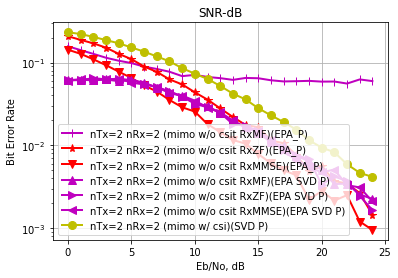

In [22]:
rxmf_epa = RxMF()

rxzf_epa = RxZF()

rxmmse_epa = RxMMSE()

rxmf_svd = RxMF_SVD_P()

rxzf_svd = RxZF_SVD_P()

rxmmse_svd = RxMMSE_SVD_P()

svd_csit = joint_svd_csit()

plt.figure()

plt.semilogy(eb_no_db, rxmf_epa, 'm|-', linewidth=2, markersize=8, label='nTx=2 nRx=2 (mimo w/o csit RxMF)(EPA_P)')

plt.semilogy(eb_no_db, rxzf_epa, 'r*-', linewidth=2, markersize=8, label='nTx=2 nRx=2 (mimo w/o csit RxZF)(EPA_P)')

plt.semilogy(eb_no_db, rxmmse_epa, 'rv-', linewidth=2, markersize=8, label='nTx=2 nRx=2 (mimo w/o csit RxMMSE)(EPA_P)')

plt.semilogy(eb_no_db, rxmf_svd, 'm^-', linewidth=2, markersize=8, label='nTx=2 nRx=2 (mimo w/o csit RxMF)(EPA SVD P)')

plt.semilogy(eb_no_db, rxzf_svd, 'm>-', linewidth=2, markersize=8, label='nTx=2 nRx=2 (mimo w/o csit RxZF)(EPA SVD P)')

plt.semilogy(eb_no_db, rxmmse_svd, 'm<-', linewidth=2, markersize=8, label='nTx=2 nRx=2 (mimo w/o csit RxMMSE)(EPA SVD P)')

plt.semilogy(eb_no_db, svd_csit, 'yo-', linewidth=2, markersize=8, label='nTx=2 nRx=2 (mimo w/ csi)(SVD P)')

plt.grid(True)
plt.legend()
plt.xlabel('Eb/No, dB')
plt.ylabel('Bit Error Rate')
plt.title('SNR-dB')
plt.show()